In [2]:
!pip install --quiet -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import ember
import pandas as pd
import numpy as np
import json
import datetime
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1

from matplotlib.lines import Line2D

from typing import Type
from ember.features import (
    PEFeatureExtractor,
    ByteHistogram,
    ByteEntropyHistogram,
    SectionInfo,
    ImportsInfo,
    ExportsInfo,
    GeneralFileInfo,
    HeaderFileInfo,
    StringExtractor,
    DataDirectories
)

# Get Feature Map

In [2]:
def histogram_map():
    return [f'histogram-{i+1}' for i in range(256)]

def entropy_map ():
    return [f'entropy-{i+1}' for i in range(256)]

def strings_map():
    features = []
    features.extend(['strings-numstrings', 'strings-avlength', 'strings-printables'])
    features.extend(f'strings-printable_dist-{i+1}' for i in range(96))
    features.extend(['strings-entropy', 'strings-paths', 'strings-urls', 'strings-registry','strings-MZ'])
    return features

def general_map():
    return ['general-size', 'general-vsize', 'general-has_debug', 'general-exports', 'general-imports', 
            'general-has_relocations', 'general-has_resources', 'general-has_signature',
            'general-has_tls', 'general-symbols']

def header_map():
    features = ['header-timestamp']
    features.extend(f'header-machine_{i+1}' for i in range(10))
    features.extend(f'header-charistics_{i+1}' for i in range(10))
    features.extend(f'header-subsystem_{i+1}' for i in range(10))
    features.extend(f'header-dll_charistics_{i+1}' for i in range(10))
    features.extend(f'header-magic_{i+1}' for i in range(10))
    features.extend(['header-major_image_ver', 'header-minor_image_ver', 'header-major_linker_ver', 
                     'header-minor_linker_ver', 'header-major_os_ver', 'header-minor_os_ver', 
                     'header-major_subsystem_ver', 'header-minor_subsystem_ver', 'header-sizeof_code',
                     'header-sizeof_headers', 'header-sizeof_heap_commit'])
    return features

def section_map():
    features = ['section-total_num', 'section-num_nonzero', 'section-num_noname', 'section-num_rx', 'section-num_w']
    features.extend(f'section-sizes_h_{i+1}' for i in range(50))
    features.extend(f'section-entropy_h_{i+1}' for i in range(50))
    features.extend(f'section-vsize_h_{i+1}' for i in range(50))
    features.extend(f'section-name_h_{i+1}' for i in range(50))
    features.extend(f'section-charistics_h_{i+1}' for i in range(50))
    return features

def imports_map():
    features = []
    features.extend(f'imports-libraries_h_{i+1}' for i in range(256))
    features.extend(f'imports-imports_h_{i+1}' for i in range(1024))
    return features

def exports_map():
    features = []
    features.extend(f'exports-hashed_{i+1}' for i in range(128))
    return features

def datadirs_map():
    features = []
    features.extend(f'datadirs-{i+1}' for i in range(30))
    return features


def get_map(feature_type) -> list:
    """ Gets the feature map based on the type """
    
    if isinstance(feature_type, ByteHistogram):
        features = histogram_map()
    
    elif isinstance(feature_type, ByteEntropyHistogram):
        features = entropy_map()
    
    elif isinstance(feature_type, SectionInfo):
        features = section_map()
    
    elif isinstance(feature_type, ImportsInfo):
        features = imports_map()
    
    elif isinstance(feature_type, ExportsInfo):
        features = exports_map()
    
    elif isinstance(feature_type, GeneralFileInfo):
        features = general_map()
    
    elif isinstance(feature_type, HeaderFileInfo):
        features = header_map()
    
    elif isinstance(feature_type, StringExtractor):
        features = strings_map()
    
    elif isinstance(feature_type, DataDirectories):
        features = datadirs_map()
        
    else:
        raise ValueError(f"Type {feature_type.__class__.__name__} is not supported")
    
    assert feature_type.dim == len(features), f"Type {feature_type.__class__.__name__} is missing features"
    return features


def feature_map():
    features = []
    for f in PEFeatureExtractor().features:
        features.extend(get_map(f))
    return features

In [3]:
def get_top_coef(coef_, n: int = 10):
    """ Returns the top coefficients by their name """
    features = feature_map()
    indices = np.argsort(np.abs(coef_))[-n:]
    return pd.DataFrame(dict(weights=coef_[indices], 
                             feature=[features[i] for i in indices], 
                             group=[features[i].split('-')[0] for i in indices]))

In [4]:
def get_avg_coef(coef_):
    average = dict()
    total_coef = max(coef_.shape)
    total_dim = 0
    for f in PEFeatureExtractor().features:
        score = np.round(np.mean(coef_[total_dim:total_dim+f.dim]), 2)
        average[f.name] = score
        total_dim += f.dim
    assert total_dim == total_coef, f"{total_dim} features != {total_coef}"
    return average

In [5]:
def get_group_coef(coef_):
    groups = []
    group_coefs = []
    total_coef = max(coef_.shape)
    total_dim = 0
    for f in PEFeatureExtractor().features:
        group = [f.name] * f.dim
        coefs = coef_[total_dim:total_dim+f.dim]
        groups.extend(group)
        group_coefs.extend(coefs.reshape(max(coefs.shape)).round(2))
        total_dim += f.dim
    assert total_dim == total_coef, f"{total_dim} features != {total_coef}"
    return pd.DataFrame(dict(weights=group_coefs, group=groups))

In [6]:
def get_zero_coef(coef_):
    total_coef = coef_.shape[0]
    feats = []
    zeros = []
    total_dim = 0
    for f in PEFeatureExtractor().features:
        coefs = coef_[total_dim:total_dim+f.dim]
        score = np.where(np.abs(coefs) < 1e-3)[0].shape[0]
        zeros.append((f.dim, score))
        feats.append(f.name)
        total_dim += f.dim
    assert total_dim == total_coef, f"{total_dim} features != {total_coef}"
    return pd.DataFrame(zeros, columns=['total_dim', 'zeros'], index=[feats])

In [7]:
features = feature_map()
len(features)

2381

In [8]:
colors = {
    'entropy':'tab:blue', 
    'exports':'tab:orange', 
    'header':'tab:green', 
    'histogram':'tab:red', 
    'imports':'tab:purple', 
    'section':'tab:brown', 
    'strings':'tab:pink',
    'general': 'tab:gray',
    'datadirs': 'tab:cyan'
}

# Processed Data

In [9]:
train_df = pd.read_parquet('data/train_df.parquet')

In [10]:
test_df = pd.read_parquet('data/test_df.parquet')

# Analyzing the Dataset

In [ ]:
from scipy import stats

In [ ]:
for column in train_df.columns[:-1]:
    alpha = 0.05
    shapiro = stats.shapiro(train_df[column]).pvalue > alpha
    agostino = stats.normaltest(train_df[column]).pvalue > alpha
    if shapiro or agostino:
        print(f"{column} is likely normal")

In [ ]:
train_df.describe()

In [36]:
def get_avg_corr_score(coef_):
    average = dict()
    for f in PEFeatureExtractor().features:
        cols = get_map(f)
        score = np.mean(coef_[cols])
        average[f.name] = score
    average['label'] = coef_['label']
    return average

## Spearman's

### All Time

In [10]:
import seaborn as sns

In [11]:
%%time
corr = pd.read_parquet('all_corr.parquet')

CPU times: user 244 ms, sys: 160 ms, total: 404 ms
Wall time: 129 ms


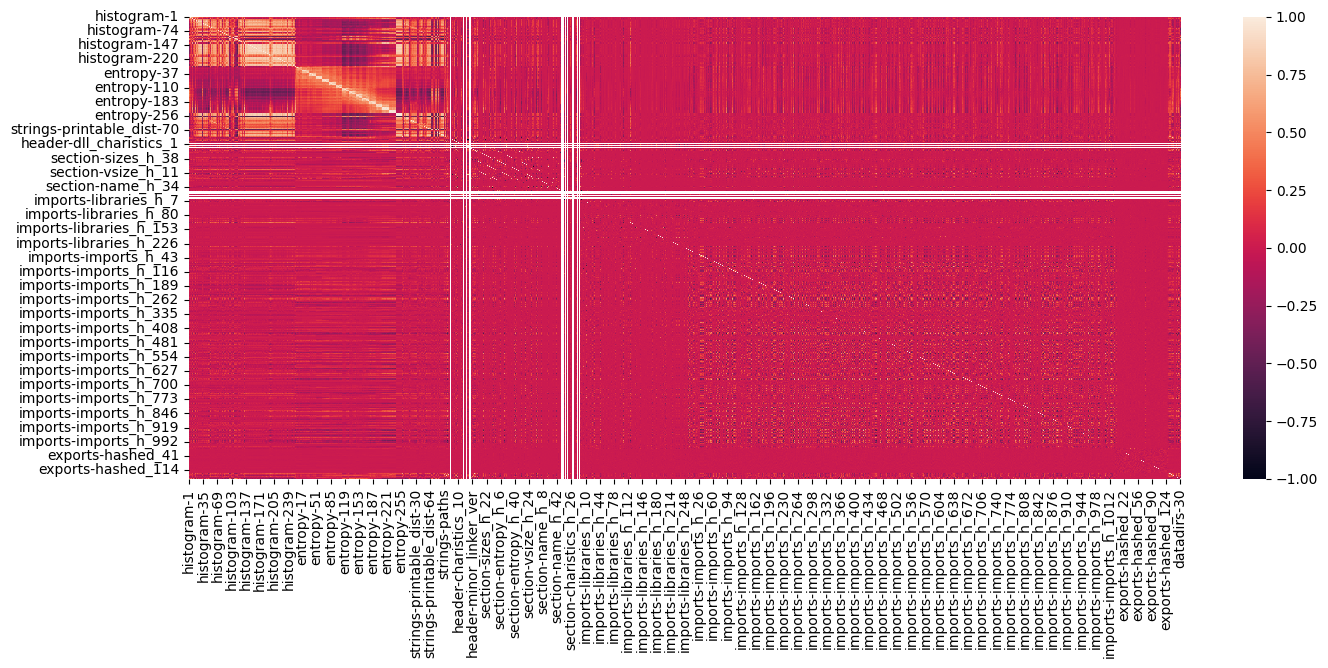

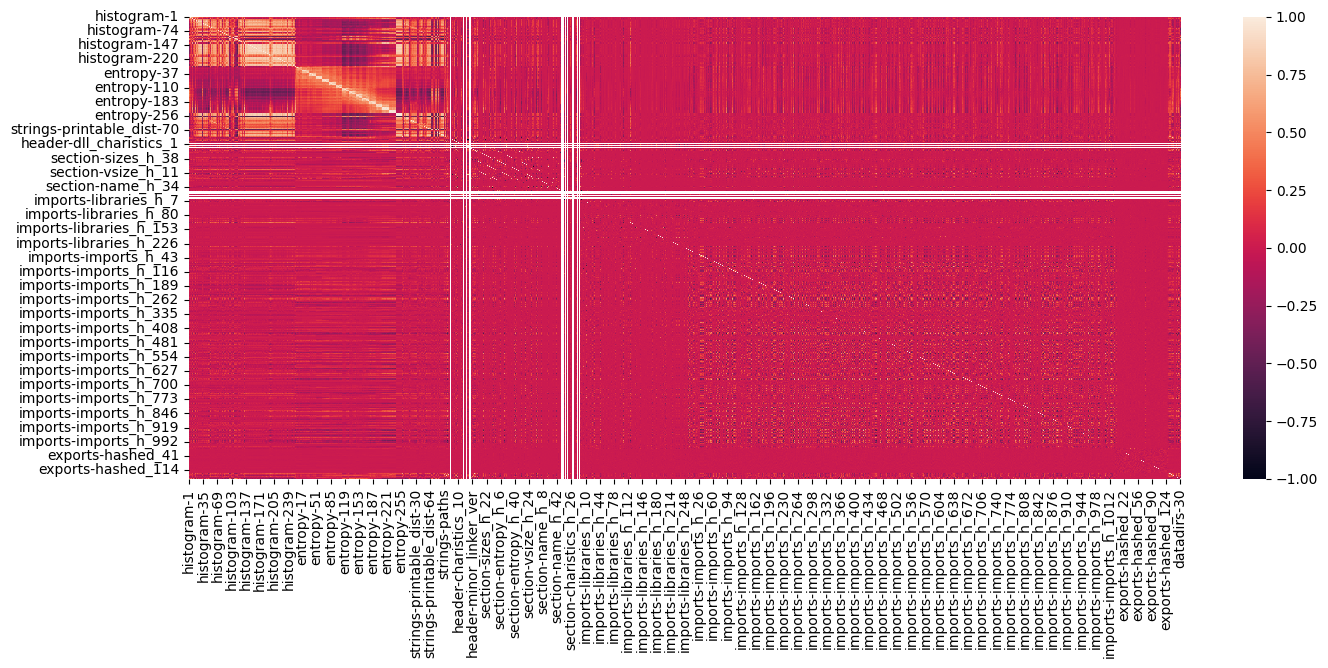

In [8]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1)
plt.show()

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(corr['label'].sort_values())

header-subsystem_9           -0.364509
histogram-2                  -0.334788
header-subsystem_8           -0.329466
datadirs-13                  -0.322953
histogram-117                -0.322140
histogram-115                -0.320980
histogram-33                 -0.316431
datadirs-9                   -0.315922
general-has_debug            -0.312856
header-charistics_4          -0.302423
histogram-112                -0.301117
entropy-129                  -0.298685
strings-printable_dist-83    -0.297652
header-charistics_5          -0.291821
datadirs-14                  -0.291227
strings-avlength             -0.290694
header-charistics_3          -0.289857
histogram-102                -0.289768
header-dll_charistics_4      -0.285097
entropy-118                  -0.284886
histogram-106                -0.281507
entropy-131                  -0.280564
entropy-134                  -0.280412
strings-printable_dist-74    -0.280320
histogram-111                -0.279798
strings-printable_dist-68

In [21]:
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

AttributeError: module 'matplotlib' has no attribute 'savefig'

# PCA

In [57]:
for name, pca in pcas.items():
    print(f"{name}: {pca.n_components_}")

histogram: 204
byteentropy: 160
strings: 81
general: 9
header: 32
section: 147
imports: 580
exports: 108
datadirectories: 13


# Regression (All)

In [12]:
X_train = train_df[train_df.columns[:-2]].to_numpy()
y_train = train_df['label'].to_numpy()
X_test = test_df[test_df.columns[:-1]].to_numpy()
y_test = test_df['label'].to_numpy()

## Model

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def create_model():
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=L1(0.01), input_dim=len(features)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrics

In [57]:
def plot_boxplot(weights, name):
    _df = get_group_coef(weights)
    ax = sns.boxplot(x="group", y="weights", data=_df[_df['weights'].abs() > 1e-3])
    ax.tick_params(axis='x', labelrotation=90)
    plt.savefig(f'img/{name}_weights_boxplot.png', bbox_inches='tight')
    plt.show()
    return
    
def plot_zero_bar(weights, name):
    zeros = get_zero_coef(weights)
    zeros.plot.barh()
    plt.savefig(f'img/{name}_weights_zeros.png', bbox_inches='tight')
    plt.show()
    return
    

def plot_top_coef(weights, name, n = 30):
    top_ = get_top_coef(np.exp(weights), n)
    fig = plt.figure(figsize=(6, 6))
    ax = plt.barh(width="weights", y="feature", color=top_['group'].map(colors), data=top_)
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
    plt.legend(title='Group', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(f'img/{name}_exp_top.png', bbox_inches='tight')
    plt.show()
    return


def plot_weight_bar(weights, name):
    _df = get_group_coef(weights)
    ax = sns.barplot(x="weights", y="group", data=_df[_df['weights'].abs() > 1e-3])
    plt.savefig('img/clf_weights_barplot.png', bbox_inches='tight')
    plt.show()
    return


def plot_all(weights, name, n = 30):
    plot_boxplot(weights, name)
    plot_zero_bar(weights, name)
    plot_top_coef(weights, name, n)
    plot_weight_bar(weights, name)

## Lasso

In [ ]:
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [17]:
clf = KerasClassifier(model=create_model, optimizer=optimizer, loss='binary_crossentropy', 
                      metrics=['accuracy'], epochs=50, batch_size=32, 
                      validation_split=0.2, validation_batch_size=32)

In [18]:
results = clf.fit(X_train, y_train)

Epoch 1/50
15000/15000 [==============================] - 17s 1ms/step - loss: 0.9624 - accuracy: 0.8224 - val_loss: 1.0557 - val_accuracy: 0.7604
Epoch 2/50
15000/15000 [==============================] - 14s 956us/step - loss: 0.9295 - accuracy: 0.8232 - val_loss: 1.2711 - val_accuracy: 0.7088
Epoch 3/50
15000/15000 [==============================] - 14s 960us/step - loss: 0.9424 - accuracy: 0.8231 - val_loss: 1.2001 - val_accuracy: 0.7507
Epoch 4/50
15000/15000 [==============================] - 14s 955us/step - loss: 0.9561 - accuracy: 0.8230 - val_loss: 1.1352 - val_accuracy: 0.7369
Epoch 5/50
15000/15000 [==============================] - 14s 954us/step - loss: 0.9396 - accuracy: 0.8238 - val_loss: 1.4378 - val_accuracy: 0.7376
Epoch 6/50
15000/15000 [==============================] - 14s 955us/step - loss: 0.9574 - accuracy: 0.8238 - val_loss: 1.1758 - val_accuracy: 0.7426
Epoch 7/50
15000/15000 [==============================] - 14s 950us/step - loss: 0.9479 - accuracy: 0.8237 -

In [19]:
clf.score(X_test, y_test)

6250/6250 [==============================] - 3s 472us/step


0.756335

In [20]:
print(classification_report(y_test, clf.predict(X_test)))

6250/6250 [==============================] - 3s 478us/step
              precision    recall  f1-score   support

         0.0       0.79      0.69      0.74    100000
         1.0       0.73      0.82      0.77    100000

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



In [31]:
classification_report(y_test, jan_clf.predict(X_test), output_dict=True)

{'0.0': {'precision': 0.883785664578984,
  'recall': 0.0127,
  'f1-score': 0.02504017271804174,
  'support': 100000},
 '1.0': {'precision': 0.5027774560215146,
  'recall': 0.99833,
  'f1-score': 0.6687566778200916,
  'support': 100000},
 'accuracy': 0.505515,
 'macro avg': {'precision': 0.6932815603002493,
  'recall': 0.505515,
  'f1-score': 0.34689842526906667,
  'support': 200000},
 'weighted avg': {'precision': 0.6932815603002492,
  'recall': 0.505515,
  'f1-score': 0.34689842526906667,
  'support': 200000}}

In [21]:
weights, bias = clf.model_.weights
weights = weights.numpy().reshape(weights.shape[0]).round(2)

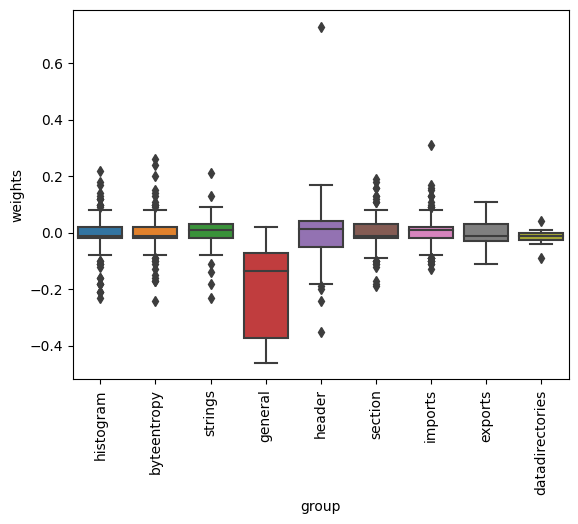

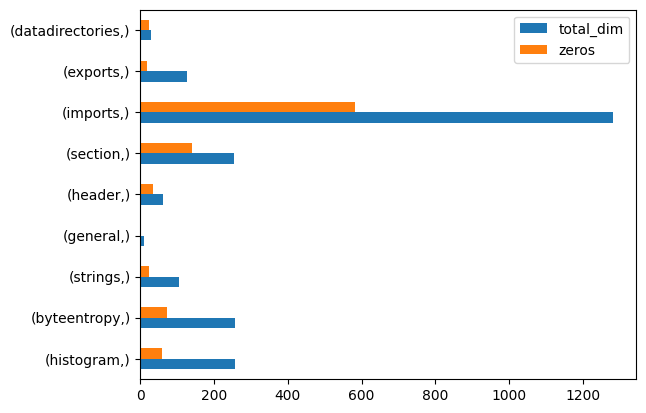

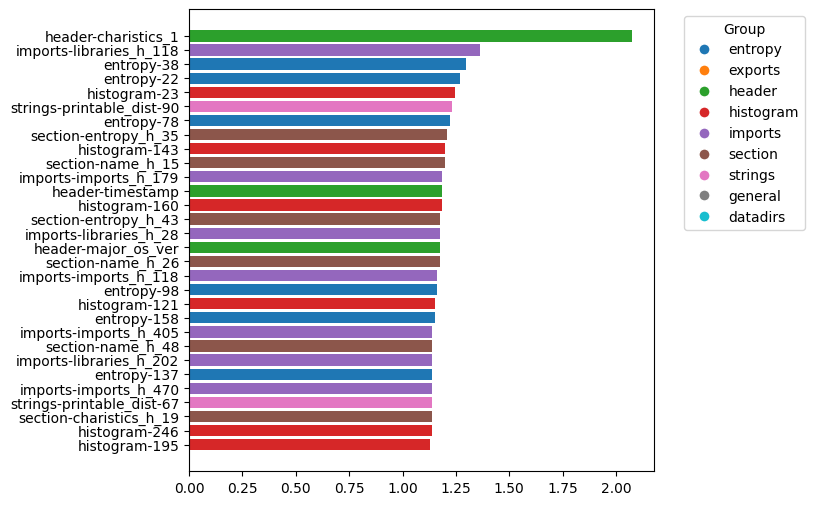

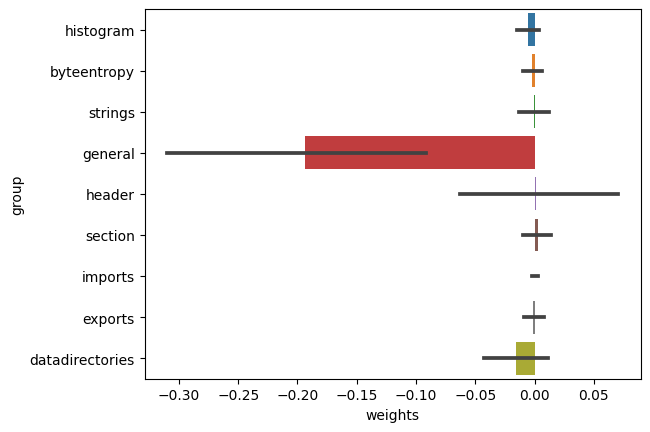

In [22]:
plot_all(weights, 'clf')

## Stats

In [ ]:
X_train = pd.DataFrame(X_train[:, np.where(np.abs(weights) >= 1e-3)[0]])
X_train.head()

In [40]:
clf_stats = sm.Logit(y_train, sm.add_constant(X_train)).fit(method='bfgs', maxiter=1)

/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
clf_stats.save('data/clf_stats.pkl')

In [41]:
print(clf_stats.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               600000
Model:                          Logit   Df Residuals:                   598573
Method:                           MLE   Df Model:                         1426
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                   0.000
Time:                        01:57:16   Log-Likelihood:            -4.1589e+05
converged:                      False   LL-Null:                   -4.1589e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                              0        nan        nan        nan         nan         nan
histogram-1                        0        nan        nan        nan         nan     

# Regression (Monthly)

In [ ]:
X_train = train_df[train_df.columns[:-2]].to_numpy()
y_train = train_df['label'].to_numpy()

In [11]:
X_test = test_df[test_df.columns[:-1]].to_numpy()
y_test = test_df['label'].to_numpy()

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def create_model():
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=L1(0.01), input_dim=len(features)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def get_balanced_df(_df, month: str):
    """ Gets a balanced dataset """
    _df = _df.loc[_df['appeared'] == pd.to_datetime(month)]
    balance = min(_df['label'].value_counts())
    _df = _df.groupby('label').sample(balance)
    counts = _df['label'].value_counts()
    assert min(counts) == max(counts)
    return _df

In [14]:
def train_month(_df, month: str):
    _df = get_balanced_df(_df, month)
    X_train = _df[_df.columns[:-2]].to_numpy()
    y_train = _df['label'].to_numpy()
    std = StandardScaler().fit(X_train)
    X_train = std.transform(X_train)
    _clf = KerasClassifier(model=create_model, optimizer=optimizer, loss='binary_crossentropy', 
                            metrics=['accuracy'], epochs=50, batch_size=32, 
                            validation_split=0.2, validation_batch_size=32, verbose=0)
    _clf.fit(X_train, y_train)
    _test = std.transform(X_test)
    report = classification_report(y_test, _clf.predict(_test), output_dict=True)
    return _clf, report

In [24]:
def train_months(_df):
    months = ['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
              '2018-08-01', '2018-09-01', '2018-10-01']
    for month in months:
        print(f"Training {month} {'#' * 80}")
        _clf, report = train_month(_df, month)
        weights, bias = _clf.model_.weights
        weights = weights.numpy().reshape(weights.shape[0]).round(2)
        zero = np.where(np.abs(weights) < 1e-3)[0].shape[0]
        benign = dict([(f'benign-{k}', v) for k,v in report['0.0'].items()])
        mal = dict([(f'mal-{k}', v) for k,v in report['1.0'].items()])
        r = {'month': month, 'accuracy': report['accuracy'], 'zero': zero, 'bias': bias[0], 'weights': weights}
        r.update(benign)
        r.update(mal)
        yield month, _clf, r

## All Months

### Train

In [25]:
models = dict()
report_df = []
iter_ = train_months(train_df)

In [44]:
month, model, r = next(iter_)
models[month] = model
report_df.append(r)

Training 2018-10-01 ################################################################################


### Stats

In [54]:
report_df = pd.read_parquet('data/report_df.parquet')

True

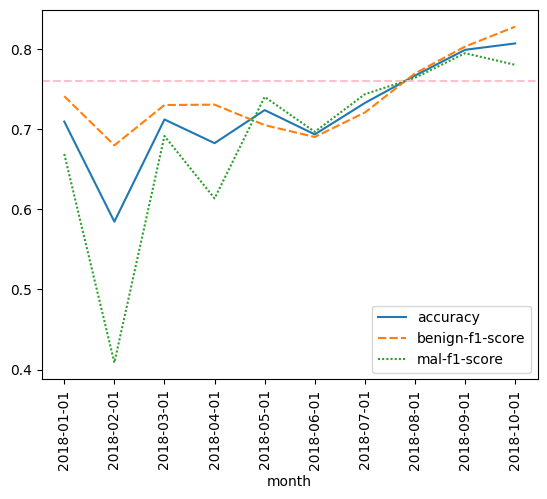

In [75]:
ax = sns.lineplot(data=df[['month', 'accuracy', 'benign-f1-score', 'mal-f1-score']].set_index('month'))
ax.axhline(0.76, color='pink', linestyle='--')
plt.xticks(rotation=90)
plt.show()

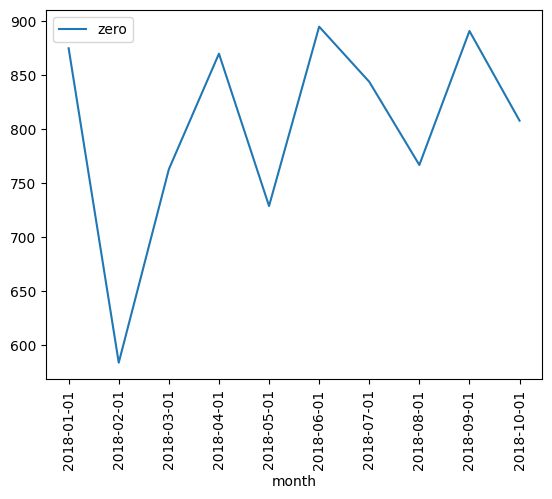

In [80]:
ax = sns.lineplot(data=df[['month', 'zero']].set_index('month'))
plt.xticks(rotation=90)
plt.show()

## 2018-01-01

In [17]:
jan_clf = train_month(train_df, '2018-01-01')

Score: 0.505515
              precision    recall  f1-score   support

         0.0       0.66      0.77      0.71    100000
         1.0       0.72      0.60      0.65    100000

    accuracy                           0.68    200000
   macro avg       0.69      0.68      0.68    200000
weighted avg       0.69      0.68      0.68    200000



In [18]:
weights, bias = jan_clf.model_.weights
weights = weights.numpy().reshape(weights.shape[0]).round(2)

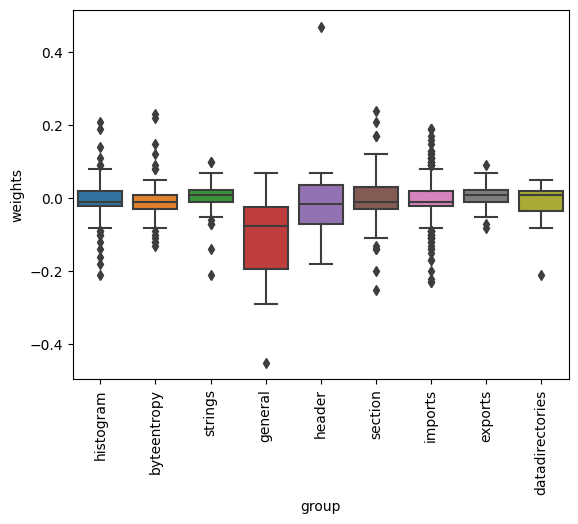

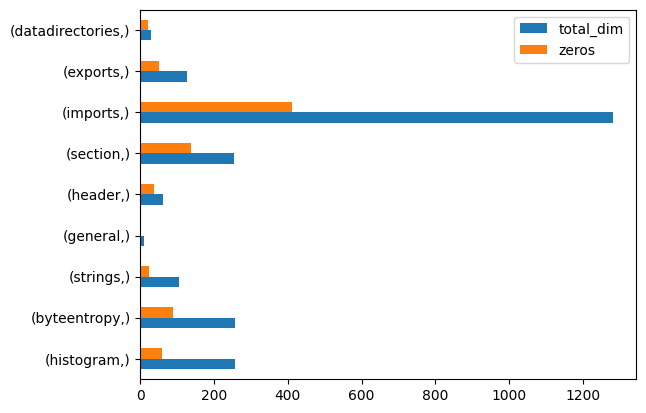

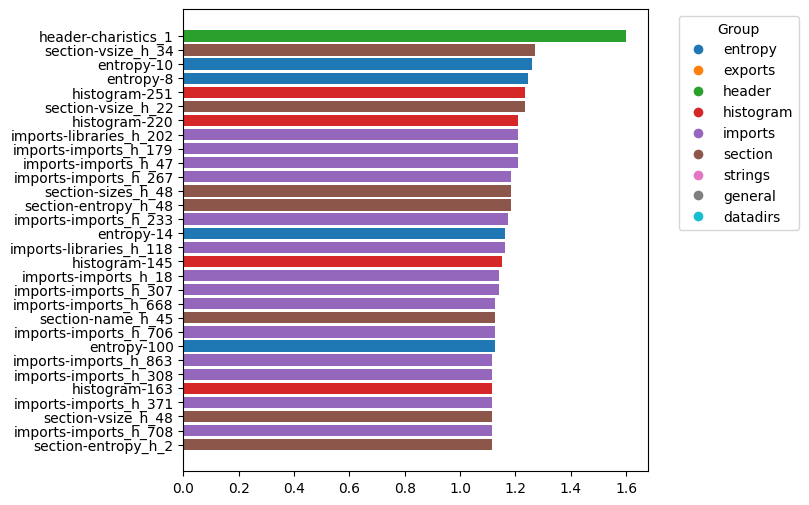

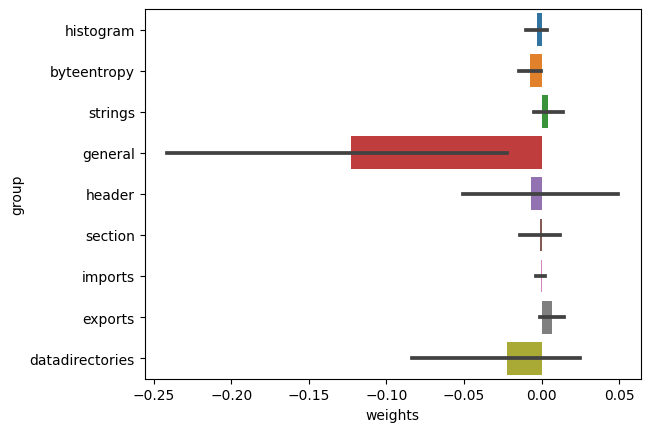

In [19]:
plot_all(weights, "jan")

In [22]:
X_train = X_train[:, np.where(np.abs(weights) >= 1e-3)[0]]
X_train = pd.DataFrame(X_train, columns=train_df.columns[np.where(np.abs(weights) >= 1e-3)[0]])

(58846, 2051)

In [31]:
X_train = pd.DataFrame(X_train, columns=train_df.columns[np.where(np.abs(weights) >= 1e-3)[0]])

In [28]:
clf_jan_stats = sm.Logit(y_train, sm.add_constant(X_train)).fit(method='bfgs', maxiter=2000)

Optimization terminated successfully.
         Current function value: 0.156609
         Iterations: 1735
         Function evaluations: 1743
         Gradient evaluations: 1743


In [29]:
print(clf_jan_stats.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                58846
Model:                          Logit   Df Residuals:                    56797
Method:                           MLE   Df Model:                         2048
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                  0.7741
Time:                        02:14:16   Log-Likelihood:                -9215.8
converged:                       True   LL-Null:                       -40789.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6091    241.498     -0.003      0.998    -473.937     472.719
x1             0.0081      0.030      0.267      0.790      -0.051       0.067
x2            -0.0792      0.034     -2.303      0.0

# 2018-02-01

In [20]:
feb_clf = train_month(train_df, '2018-02-01')

Score: 0.52116
              precision    recall  f1-score   support

         0.0       0.65      0.79      0.71    100000
         1.0       0.73      0.58      0.65    100000

    accuracy                           0.69    200000
   macro avg       0.69      0.69      0.68    200000
weighted avg       0.69      0.69      0.68    200000



In [21]:
weights, bias = feb_clf.model_.weights
weights = weights.numpy().reshape(weights.shape[0]).round(2)

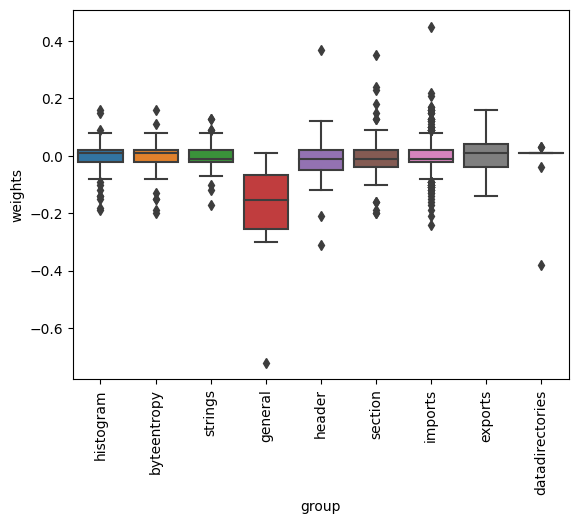

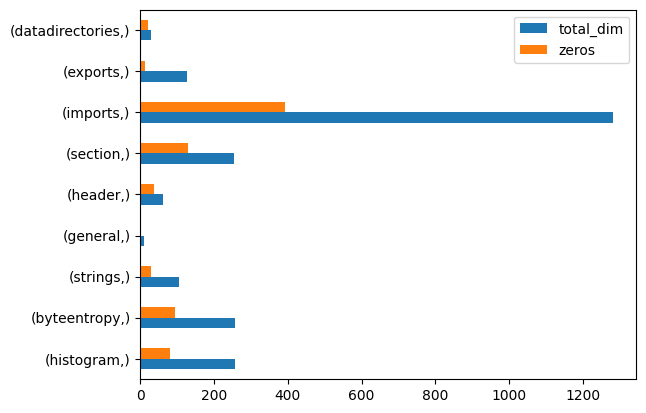

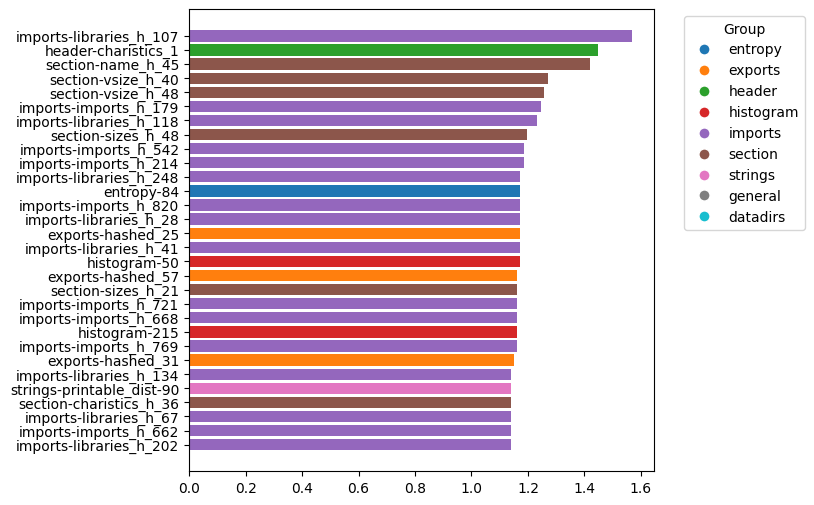

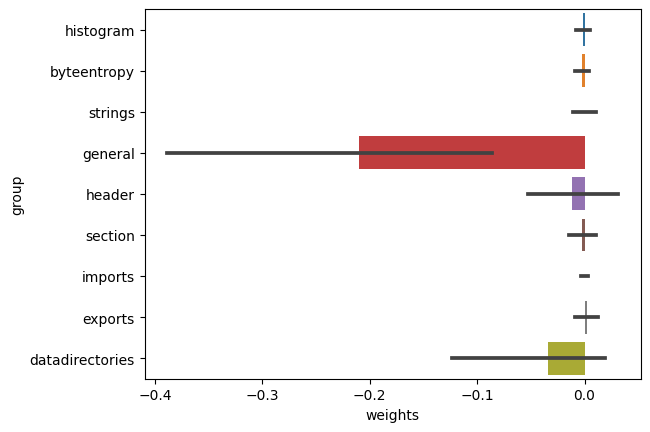

In [22]:
plot_all(weights, "feb")

## 2018-06-01

In [23]:
june_clf = train_month(train_df, '2018-06-01')

Score: 0.492465
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74    100000
         1.0       0.73      0.80      0.77    100000

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.75    200000
weighted avg       0.76      0.76      0.75    200000



In [24]:
weights, bias = feb_clf.model_.weights
weights = weights.numpy().reshape(weights.shape[0]).round(2)

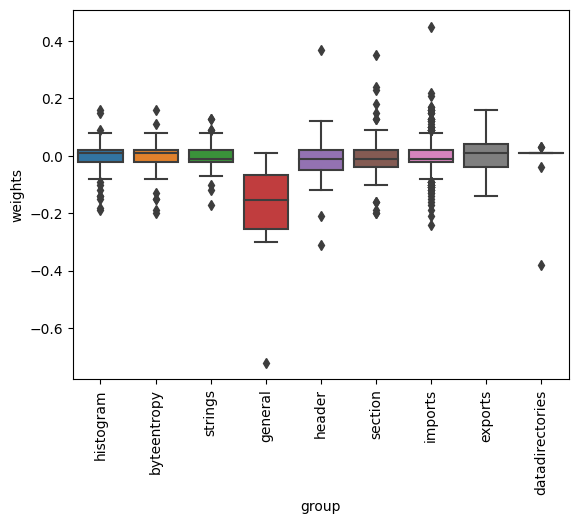

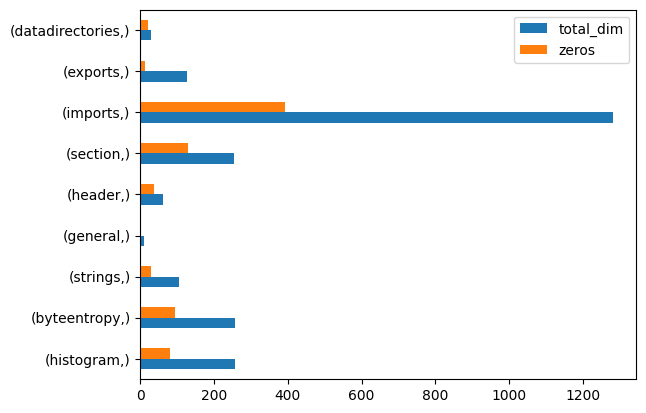

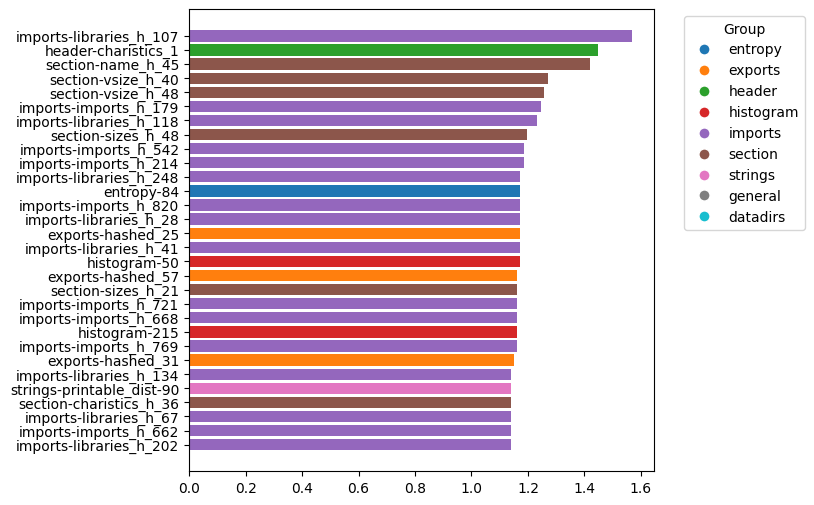

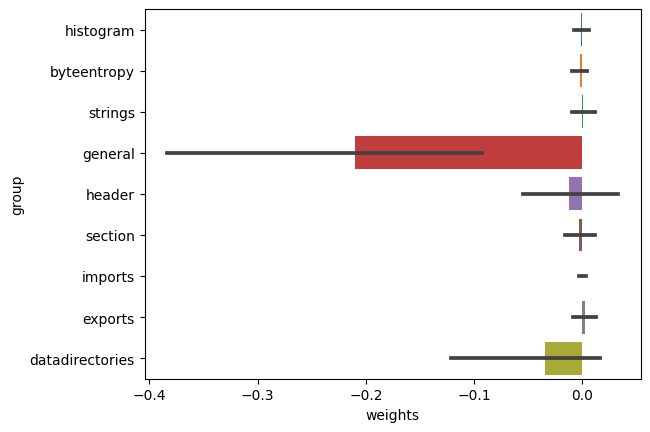

In [25]:
plot_all(weights, "june")

## 2018-10-01

In [26]:
oct_clf = train_month(train_df, '2018-10-01')

Score: 0.518905
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83    100000
         1.0       0.88      0.73      0.80    100000

    accuracy                           0.81    200000
   macro avg       0.82      0.81      0.81    200000
weighted avg       0.82      0.81      0.81    200000



In [27]:
weights, bias = oct_clf.model_.weights
weights = weights.numpy().reshape(weights.shape[0]).round(2)

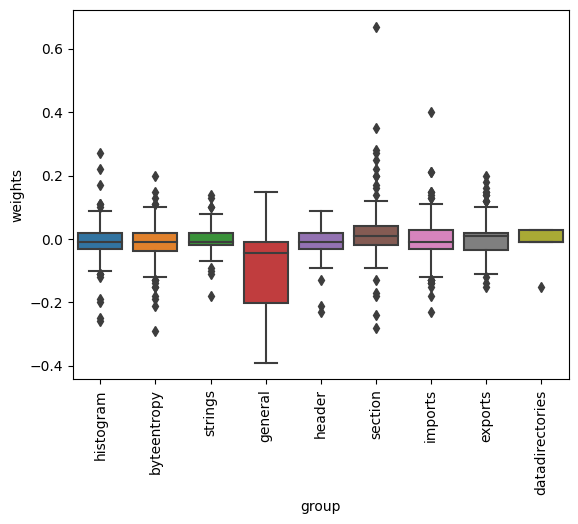

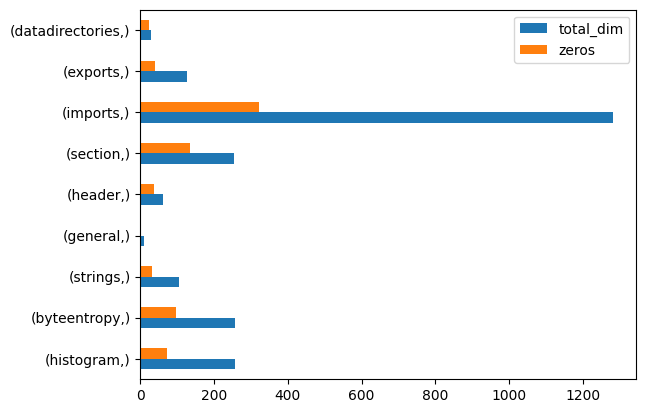

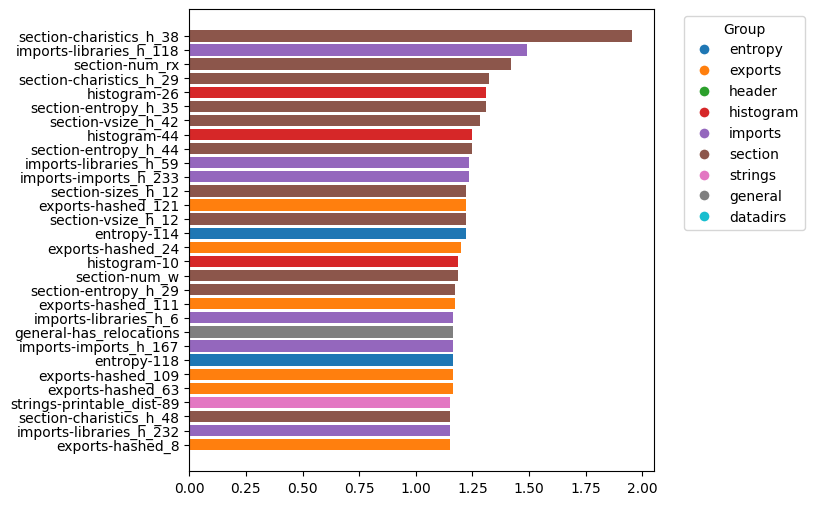

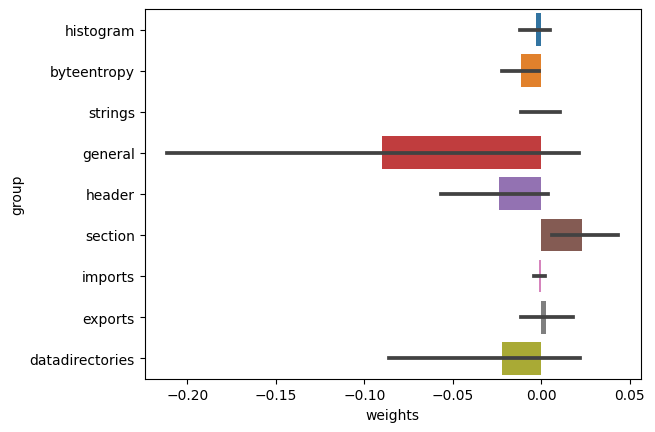

In [28]:
plot_all(weights, "oct")

# PCA

In [ ]:
pca_train_df = pd.read_parquet('data/pca_train_df.parquet')
pca_test_df = pd.read_parquet('data/pca_test_df.parquet')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def create_model():
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=L1(0.01), input_dim=len(features)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
X_train = train_df[train_df.columns[:-2]].to_numpy()
y_train = train_df['label'].to_numpy()
X_test = test_df[test_df.columns[:-1]].to_numpy()
y_test = test_df['label'].to_numpy()

## Regression (All)

In [ ]:
pca_clf = KerasClassifier(model=create_model, optimizer=optimizer, loss='binary_crossentropy', 
                        metrics=['accuracy'], epochs=50, batch_size=32, 
                        validation_split=0.2, validation_batch_size=32, verbose=0)

In [ ]:
results = pca_clf.fit(X_train, y_train)

In [7]:
def plot_weights(coef_):
    
    def yield_x_y(coef_):
        total_dim = 0
        for f in PEFeatureExtractor().features:
            feats = np.array(get_map(f))
            coefs = coef_[total_dim:total_dim+f.dim]
            nonzero = np.where(np.abs(coefs) > 1e-3)[0]
            yield feats[nonzero], coefs[nonzero]
            total_dim += f.dim
            
    i = yield_x_y(coef_)
    fig, axs = plt.subplots(3, 3)
    x, y = next(i)
    axs[0, 0].bar(x, y)
    axs[0, 0].set_title('Axis [0, 0]')
    x, y = next(i)
    axs[0, 1].bar(x, y, 'tab:orange')
    axs[0, 1].set_title('Axis [0, 1]')
    x, y = next(i)
    axs[0, 2].bar(x, y, 'tab:orange')
    axs[0, 2].set_title('Axis [0, 1]')
    
    x, y = next(i)
    axs[1, 0].bar(x, y, 'tab:green')
    axs[1, 0].set_title('Axis [1, 0]')
    x, y = next(i)
    axs[1, 1].bar(x, y, 'tab:red')
    axs[1, 1].set_title('Axis [1, 1]')
    x, y = next(i)
    axs[1, 2].bar(x, y, 'tab:red')
    axs[1, 2].set_title('Axis [1, 1]')
    
    x, y = next(i)
    axs[2, 0].bar(x, y, 'tab:red')
    axs[2, 0].set_title('Axis [1, 1]')
    x, y = next(i)
    axs[2, 1].bar(x, y, 'tab:red')
    axs[2, 1].set_title('Axis [1, 1]')
    x, y = next(i)
    axs[2, 2].bar(x, y, 'tab:red')
    axs[2, 2].set_title('Axis [1, 1]')

    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    
    return fig, axs